<a href="https://colab.research.google.com/github/f247805/DeepLearning/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pythonafroz/solar-panel-images")

print("Path to dataset files:", path)

100%|██████████| 305M/305M [00:01<00:00, 224MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pythonafroz/solar-panel-images/versions/2


In [16]:
import os

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/pythonafroz/solar-panel-images/versions/2"

# List the folders (classes)
print("Dataset Classes:", os.listdir(dataset_path))


Dataset Classes: ['Faulty_solar_panel']


In [17]:
import shutil

# Move dataset to /content/
shutil.move(dataset_path, "/content/solar-panel-images")

# Verify move
print("Dataset moved successfully to /content/")


Dataset moved successfully to /content/


In [27]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks

# ======================
# Configuration
# ======================
BASE_PATH = "/content/solar-panel-images"
DATASET_PATH = os.path.join(BASE_PATH, "Faulty_solar_panel")
EXPECTED_CLASSES = [
    'bird-drop', 'clean', 'dusty',
    'electrical-damage', 'physical-damage', 'snow-covered'
]

def create_data_generators(class_map):
    """Handle directories and files properly"""
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')

    # Clean each class directory
    for cls_dir in class_map.values():
        class_path = os.path.join(DATASET_PATH, cls_dir)

        # Process all entries in the directory
        for entry in os.listdir(class_path):
            entry_path = os.path.join(class_path, entry)

            if os.path.isfile(entry_path):
                # Delete non-image files
                if not entry.lower().endswith(valid_exts):
                    os.remove(entry_path)
                    print(f"Removed file: {entry_path}")
            elif os.path.isdir(entry_path):
                # Remove subdirectories recursively
                shutil.rmtree(entry_path)
                print(f"Removed directory: {entry_path}")

    # Create data generators
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
        validation_split=0.15
    )

    train_gen = train_datagen.flow_from_directory(
        directory=DATASET_PATH,
        classes=list(class_map.values()),
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    val_gen = train_datagen.flow_from_directory(
        directory=DATASET_PATH,
        classes=list(class_map.values()),
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_gen, val_gen

Found directories: ['Physical-Damage', 'Electrical-damage', 'Snow-Covered', 'Dusty', 'Clean', 'Bird-drop']

Class directory mapping:
bird-drop            => Bird-drop
clean                => Clean
dusty                => Dusty
electrical-damage    => Electrical-damage
physical-damage      => Physical-Damage
snow-covered         => Snow-Covered
Removed directory: /content/solar-panel-images/Faulty_solar_panel/Bird-drop/New
Found 742 images belonging to 6 classes.
Found 127 images belonging to 6 classes.

Training samples: 742
Validation samples: 127


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - auc: 0.1886 - loss: 10.2672 - precision: 0.2604 - recall: 0.0394 - val_auc: 0.1844 - val_loss: 9.9567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 681ms/step - auc: 0.1787 - loss: 10.2080 - precision: 0.1877 - recall: 0.0253 - val_auc: 0.2020 - val_loss: 9.9159 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 785ms/step - auc: 0.2009 - loss: 10.1189 - precision: 0.1963 - recall: 0.0282 - val_auc: 0.2314 - val_loss: 9.8555 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 694ms/step - auc: 0.2315 - loss: 9.9880 - precision: 0.3890 - recall: 0.0555 - val_auc: 0.2900 - val_loss: 9.7734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 692ms/step

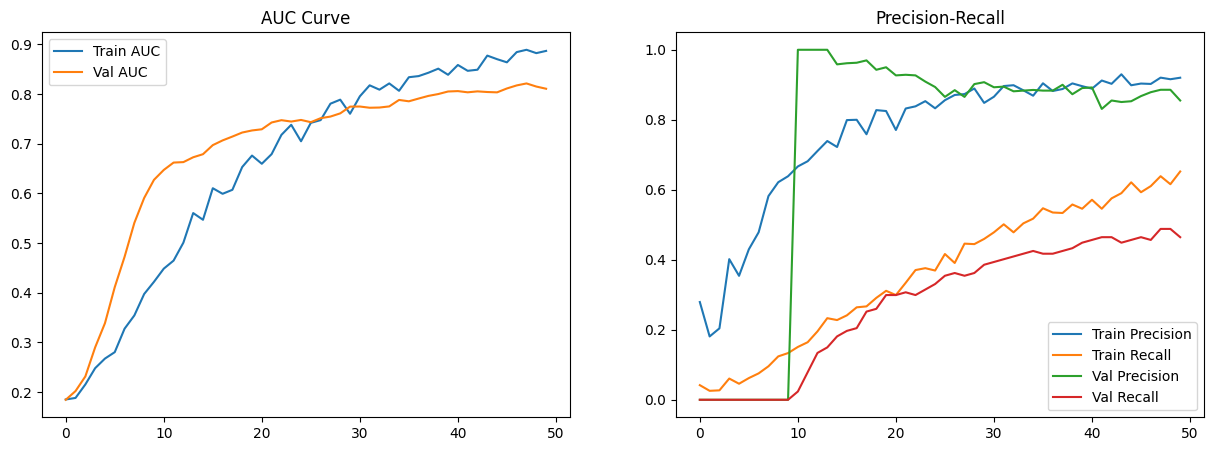

In [28]:
# ======================
# Model Architecture
# ======================
def build_model(class_weights):
    base_model = applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Fine-tuning strategy
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = isinstance(layer, layers.BatchNormalization)

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer='l2'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(EXPECTED_CLASSES), activation='softmax')
    ])

    # Class-weighted loss
    weighted_loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.1
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss=weighted_loss,
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc', curve='PR')
        ]
    )

    return model

# ======================
# Training & Evaluation
# ======================
def main():
    # 1. Verify dataset structure
    class_map = verify_and_map_classes()

    # 2. Create data generators
    train_gen, val_gen = create_data_generators(class_map)
    print(f"\nTraining samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")

    # 3. Calculate class weights
    class_counts = {k: len(os.listdir(os.path.join(DATASET_PATH, v)))
                   for k, v in class_map.items()}
    total = sum(class_counts.values())
    class_weights = {i: total/(len(class_counts)*count)
                    for i, (cls, count) in enumerate(class_counts.items())}

    # 4. Build and train model
    model = build_model(class_weights)

    history = model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[
            callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
            callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
        ],
        class_weight=class_weights
    )

    # 5. Evaluation
    model = models.load_model('best_model.keras')

    # Plot training history
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Precision-Recall')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()